In [1]:
import pickle
from training import Training
import torch

In [2]:

# File paths for all three embeddings
embeddings_files = [
    "extracted_data/GPT embeddings/mcar_beta0_gpt_emb.pickle",
    "extracted_data/GPT embeddings/noise0.6_gpt_emb.pickle",
    "extracted_data/GPT embeddings/mcar_beta0.1_gpt_emb.pickle",
    "extracted_data/GPT embeddings/mnar_beta0.1_gpt_emb.pickle",
    "extracted_data/GPT embeddings/mcar_beta0.1_gpt_emb.pickle"
]


In [3]:
import pickle
with open(embeddings_files[3],'rb') as handle:
    mnar_embeddings = pickle.load(handle)


In [4]:
model_name = 'mlp'
# torch.cuda.set_device(0)
device = torch.device('cpu')
# training = Training(trends_data, model = model_name, device = device)
# training = Training(trends_data, model = model_name, hidden_dim = 1536, device = device)
# training = Training(trends_data, model = model_name, input_dim = 1536, hidden_dim=128, device = device)
training = Training(mnar_embeddings, model = model_name, input_dim = 1536, hidden_dim=1536, device = device)

normalize data
create datasets
create trainloaders


TypeError: MLP.__init__() takes 4 positional arguments but 5 were given

In [11]:
import torch
import pickle
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Set the device for PyTorch (use 'cuda' for GPU if available)
device = torch.device('cpu')  # Change to 'cuda' if using GPU
random.seed(111)
# Define lists for model configurations you want to try
model_names = ['lr']  # List of model names/configurations
annotations = ['_lr0.01']  # List of annotations to distinguish model variants
learning_rates = [0.01]  # List of learning rates to try

# Define model parameters (modify as per your requirements)
input_dim = 1536
hidden_dim = 1536

# Loop through each learning rate, model configuration, and dataset
for lr in learning_rates:
    for model_name in model_names:
        for add_annot in annotations:
            for filename in ["extracted_data/GPT embeddings/mnar_beta0.1_gpt_emb.pickle",
    "extracted_data/GPT embeddings/mcar_beta0.1_gpt_emb.pickle"]:
                if filename.endswith('.pickle'):
                    # Extract the dataset name without the file extension
                    name = filename.replace('.pickle', '')

                    # Load the dataset
                    with open(f'{name}.pickle', 'rb') as handle:
                        trends_data = pickle.load(handle)

                    # Initialize the Training class with specified parameters
                    training = Training(
                        trends_data,
                        model=model_name,
                        input_dim=input_dim,
                        hidden_dim=hidden_dim,
                        device=device,
                        dropout= 0.5
                    )

                    # Run the training process with the specified learning rate
                    best_model, train_loss, val_loss = training.training(lr=lr)  # Pass the learning rate here

                    # Define paths for saving model and loss data
                    model_save_path = f'outputs/baseline_{model_name}_{name}{add_annot}_lr{lr}.pt'
                    train_loss_save_path = f'outputs/train_losses_{model_name}_{name}{add_annot}_lr{lr}.pickle'
                    val_loss_save_path = f'outputs/val_losses_{model_name}_{name}{add_annot}_lr{lr}.pickle'

                    # Save the trained model
                    try:
                        torch.save(best_model, model_save_path)
                        print(f"Model saved as {model_save_path}")
                    except Exception as e:
                        print(f"Error saving model: {e}")

                    # Save training and validation losses
                    with open(train_loss_save_path, 'wb') as handle:
                        pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
                    print(f"Training losses saved as {train_loss_save_path}")

                    with open(val_loss_save_path, 'wb') as handle:
                        pickle.dump(val_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
                    print(f"Validation losses saved as {val_loss_save_path}")

                    # Plot training and validation losses
                    plt.plot(train_loss, label='Training Loss')
                    plt.plot(val_loss, label='Validation Loss')
                    plt.xlabel('Epochs')
                    plt.ylabel('Loss')
                    plt.legend(['Training Loss', 'Validation Loss'])
                    plt.title(f'Training and Validation Losses for {name} - {model_name} with lr={lr}')
                    plt.show()

                    # Initialize the test loader and load the trained model
                    test_loader = training.data_splits.test_loader
                    model = training.model

                    # Load the trained model state if it exists
                    if os.path.exists(model_save_path):
                        try:
                            model.load_state_dict(torch.load(model_save_path, map_location=device))
                            print(f"Model loaded from {model_save_path}")
                        except Exception as e:
                            print(f"Error loading model: {e}")
                    else:
                        print(f"Model file not found: {model_save_path}")

                    # Function to create a padding mask
                    def create_padding_mask(seq_lengths, max_len):
                        batch_size = len(seq_lengths)
                        mask = torch.zeros(batch_size, max_len, dtype=torch.bool)
                        for i, seq_len in enumerate(seq_lengths):
                            mask[i, seq_len:] = True
                        return mask

                    # Evaluate the model
                    model.eval()
                    all_outputs, all_labels = [], []
                    with torch.no_grad():
                        for sequences, labels in test_loader:
                            sequences, labels = sequences.to(device), labels.float().to(device)
                            seq_lengths = [len(seq[seq != 0]) for seq in sequences]
                            max_len = sequences.size(1)
                            mask = create_padding_mask(seq_lengths, max_len).to(device)
                            outputs = model(sequences, mask)
                            all_outputs.extend(outputs.detach().cpu().numpy())
                            all_labels.extend(labels.detach().cpu().numpy())

                    # Function to plot ROC and PR curves
                    def roc_pr(outputs, labels, plot='no'):
                        fpr, tpr, _ = roc_curve(np.array(labels), np.array(outputs))
                        pre, rec, _ = precision_recall_curve(np.array(labels), np.array(outputs))

                        if plot == 'yes':
                            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
                            roc_auc = auc(fpr, tpr)
                            ax1.plot(fpr, tpr, color='b', label=f'AUROC: {roc_auc:.4f}')
                            pr_auc = auc(rec, pre)
                            ax2.plot(rec, pre, color='b', label=f'AUPR: {pr_auc:.4f}')
                            ax1.set_title('ROC Curve')
                            ax1.set_xlabel('False Positive Rate')
                            ax1.set_ylabel('True Positive Rate')
                            ax1.legend(loc="lower right")
                            ax2.set_title('Precision-Recall Curve')
                            ax2.set_xlabel('Recall')
                            ax2.set_ylabel('Precision')
                            ax2.legend(loc="lower left")
                            plt.tight_layout()
                            plt.show()

                    # Plot ROC and PR curves
                    roc_pr(all_outputs, all_labels, plot='yes')


normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.8879040018717448
Epoch [1/2000], Val Loss: 0.9804080686569214
Epoch [2/2000], Train Loss: 0.8183181902567546
Epoch [2/2000], Val Loss: 0.6589563603401184
Epoch [3/2000], Train Loss: 0.7726544206937154
Epoch [3/2000], Val Loss: 0.7341069002151489
Epoch [4/2000], Train Loss: 0.8030069174766541
Epoch [4/2000], Val Loss: 0.871525422334671
Epoch [5/2000], Train Loss: 0.769674026966095
Epoch [5/2000], Val Loss: 0.7161285569667816
Epoch [6/2000], Train Loss: 0.7550847361882528
Epoch [6/2000], Val Loss: 1.1057767534255982
Epoch [7/2000], Train Loss: 0.7719454191525777
Epoch [7/2000], Val Loss: 0.6546432716846466
Epoch [8/2000], Train Loss: 0.7444553502400716
Epoch [8/2000], Val Loss: 0.6437199766635895
Epoch [9/2000], Train Loss: 0.7995903689861298
Epoch [9/2000], Val Loss: 0.6583016741275788
Epoch [10/2000], Train Loss: 0.7963984835942586
Epoch [10/2000], Val Loss: 0.6406691768169404
Epoch [11/2000], Train Loss: 

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/train_losses_lr_extracted_data/GPT embeddings/mnar_beta0.1_gpt_emb_lr0.01_lr0.01.pickle'

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.7119976205825805
Epoch [1/2000], Val Loss: 0.7075949840545654
Epoch [2/2000], Train Loss: 0.7060064185460408
Epoch [2/2000], Val Loss: 0.701947274684906
Epoch [3/2000], Train Loss: 0.701934966246287
Epoch [3/2000], Val Loss: 0.697174602985382
Epoch [4/2000], Train Loss: 0.6980995321273804
Epoch [4/2000], Val Loss: 0.6969878544807434
Epoch [5/2000], Train Loss: 0.6952145476341247
Epoch [5/2000], Val Loss: 0.6909140934944152
Epoch [6/2000], Train Loss: 0.6902891731262207
Epoch [6/2000], Val Loss: 0.6908812823295594
Epoch [7/2000], Train Loss: 0.6886410077412923
Epoch [7/2000], Val Loss: 0.6856372585296631
Epoch [8/2000], Train Loss: 0.6871047897338867
Epoch [8/2000], Val Loss: 0.6890083665847778
Epoch [9/2000], Train Loss: 0.6855978620847066
Epoch [9/2000], Val Loss: 0.6822536206245422
Epoch [10/2000], Train Loss: 0.6817828160921733
Epoch [10/2000], Val Loss: 0.6845132412910462
Epoch [11/2000], Train Loss: 0

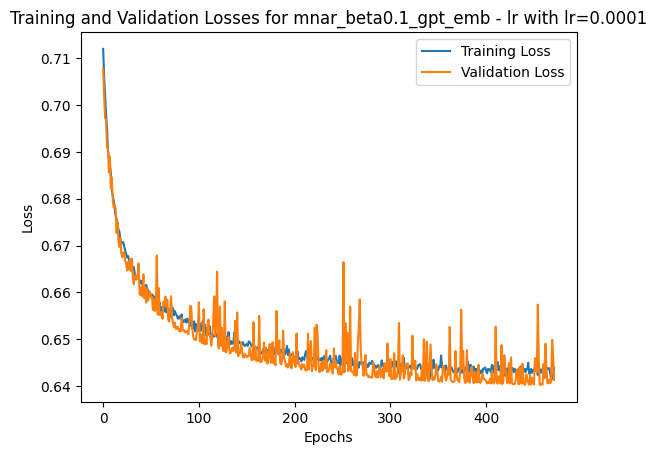

C:\Users\kr3164\AppData\Local\Temp\ipykernel_4344\1627316668.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs\baseline_lr_mnar_beta0.1_gpt_emb_lr0.0001.pt


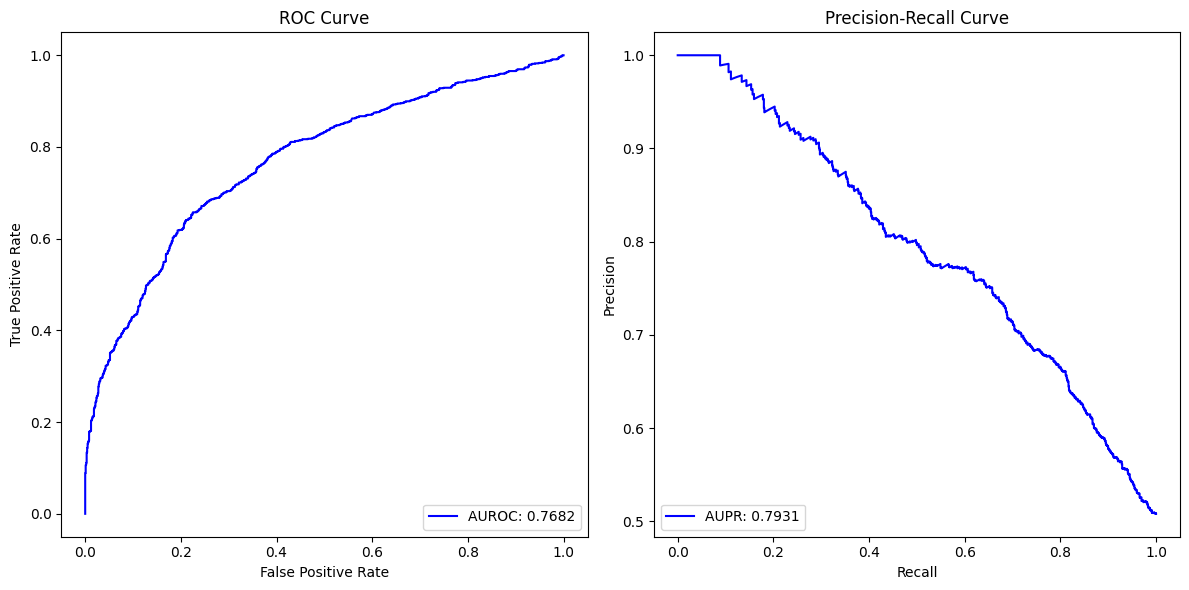

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.7142364435195923
Epoch [1/2000], Val Loss: 0.7094108800888062
Epoch [2/2000], Train Loss: 0.7100030363400777
Epoch [2/2000], Val Loss: 0.7097599234580994
Epoch [3/2000], Train Loss: 0.7091944406827291
Epoch [3/2000], Val Loss: 0.7065370454788208
Epoch [4/2000], Train Loss: 0.7051736954053243
Epoch [4/2000], Val Loss: 0.7023651385307312
Epoch [5/2000], Train Loss: 0.7039529267946879
Epoch [5/2000], Val Loss: 0.7005218267440796
Epoch [6/2000], Train Loss: 0.702154129187266
Epoch [6/2000], Val Loss: 0.703571457862854
Epoch [7/2000], Train Loss: 0.6993031625747681
Epoch [7/2000], Val Loss: 0.7039931468963623
Epoch [8/2000], Train Loss: 0.6977103575070699
Epoch [8/2000], Val Loss: 0.6961692643165588
Epoch [9/2000], Train Loss: 0.6975711483955384
Epoch [9/2000], Val Loss: 0.6944937725067138
Epoch [10/2000], Train Loss: 0.695702932993571
Epoch [10/2000], Val Loss: 0.6933831882476806
Epoch [11/2000], Train Loss: 0

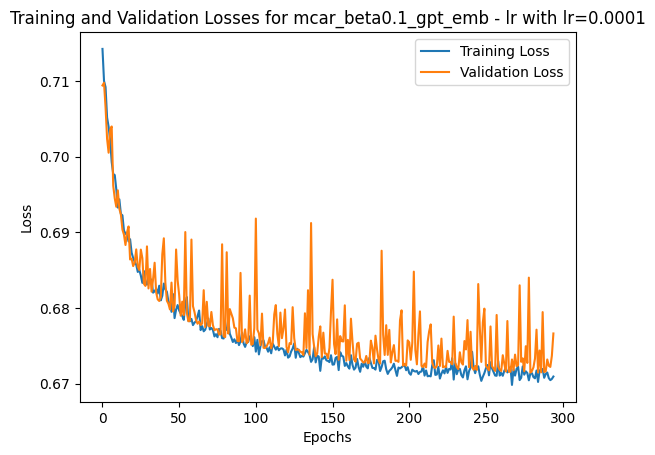

C:\Users\kr3164\AppData\Local\Temp\ipykernel_4344\1627316668.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs\baseline_lr_mcar_beta0.1_gpt_emb_lr0.0001.pt


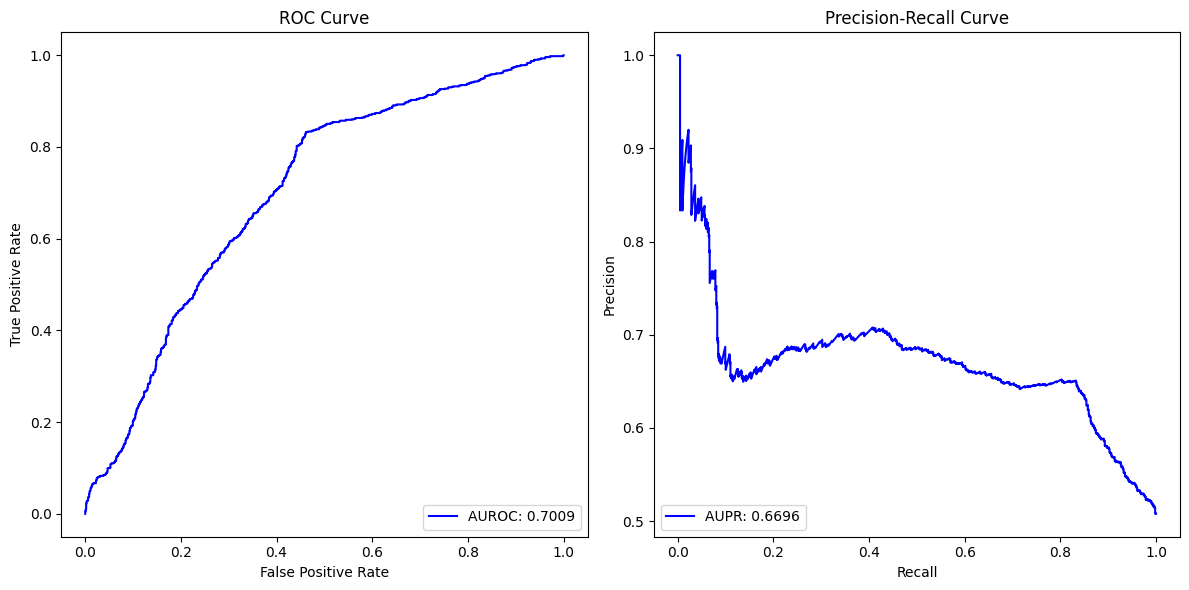

In [14]:
import torch
import pickle
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Set the device for PyTorch (use 'cuda' for GPU if available)
device = torch.device('cpu')  # Change to 'cuda' if using GPU
random.seed(111)

# Define model parameters (modify as per your requirements)
model_name = 'lr'
input_dim = 1536
hidden_dim = 1536
dropout_rate = 0.5
learning_rate = 0.0001

# Ensure the output directory exists
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

# List of files to process
file_list = [
    "extracted_data/GPT embeddings/mnar_beta0.1_gpt_emb.pickle",
    "extracted_data/GPT embeddings/mcar_beta0.1_gpt_emb.pickle"
]

# Process each file
for filename in file_list:
    # Load the dataset
    with open(filename, 'rb') as handle:
        trends_data = pickle.load(handle)

    # Initialize the Training class with specified parameters
    training = Training(
        trends_data,
        model=model_name,
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        device=device,
        dropout=dropout_rate
    )

    # Run the training process with the specified learning rate
    best_model, train_loss, val_loss = training.training(lr=learning_rate)  # Pass the learning rate here

    # Extract the dataset name without the file extension
    name = os.path.splitext(os.path.basename(filename))[0]

    # Define paths for saving model and loss data
    model_save_path = os.path.join(output_dir, f'baseline_{model_name}_{name}_lr{learning_rate}.pt')
    train_loss_save_path = os.path.join(output_dir, f'train_losses_{model_name}_{name}_lr{learning_rate}.pickle')
    val_loss_save_path = os.path.join(output_dir, f'val_losses_{model_name}_{name}_lr{learning_rate}.pickle')

    # Save the trained model
    try:
        torch.save(best_model, model_save_path)
        print(f"Model saved as {model_save_path}")
    except Exception as e:
        print(f"Error saving model: {e}")

    # Save training and validation losses
    with open(train_loss_save_path, 'wb') as handle:
        pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Training losses saved as {train_loss_save_path}")

    with open(val_loss_save_path, 'wb') as handle:
        pickle.dump(val_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Validation losses saved as {val_loss_save_path}")

    # Plot training and validation losses
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.title(f'Training and Validation Losses for {name} - {model_name} with lr={learning_rate}')
    plt.show()

    # Initialize the test loader and load the trained model
    test_loader = training.data_splits.test_loader
    model = training.model

    # Load the trained model state if it exists
    if os.path.exists(model_save_path):
        try:
            model.load_state_dict(torch.load(model_save_path, map_location=device))
            print(f"Model loaded from {model_save_path}")
        except Exception as e:
            print(f"Error loading model: {e}")
    else:
        print(f"Model file not found: {model_save_path}")

    # Function to create a padding mask
    def create_padding_mask(seq_lengths, max_len):
        batch_size = len(seq_lengths)
        mask = torch.zeros(batch_size, max_len, dtype=torch.bool)
        for i, seq_len in enumerate(seq_lengths):
            mask[i, seq_len:] = True
        return mask

    # Evaluate the model
    model.eval()
    all_outputs, all_labels = [], []
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.float().to(device)
            seq_lengths = [len(seq[seq != 0]) for seq in sequences]
            max_len = sequences.size(1)
            mask = create_padding_mask(seq_lengths, max_len).to(device)
            outputs = model(sequences, mask)
            all_outputs.extend(outputs.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

    # Function to plot ROC and PR curves
    def roc_pr(outputs, labels, plot='yes'):
        fpr, tpr, _ = roc_curve(np.array(labels), np.array(outputs))
        pre, rec, _ = precision_recall_curve(np.array(labels), np.array(outputs))

        if plot == 'yes':
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
            roc_auc = auc(fpr, tpr)
            ax1.plot(fpr, tpr, color='b', label=f'AUROC: {roc_auc:.4f}')
            pr_auc = auc(rec, pre)
            ax2.plot(rec, pre, color='b', label=f'AUPR: {pr_auc:.4f}')
            ax1.set_title('ROC Curve')
            ax1.set_xlabel('False Positive Rate')
            ax1.set_ylabel('True Positive Rate')
            ax1.legend(loc="lower right")
            ax2.set_title('Precision-Recall Curve')
            ax2.set_xlabel('Recall')
            ax2.set_ylabel('Precision')
            ax2.legend(loc="lower left")
            plt.tight_layout()
            plt.show()

    # Plot ROC and PR curves
    roc_pr(all_outputs, all_labels, plot='yes')


normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 1.787033626874288
Epoch [1/2000], Val Loss: 1.4058493728637695
Epoch [2/2000], Train Loss: 1.1647787537574767
Epoch [2/2000], Val Loss: 0.9707012171745301
Epoch [3/2000], Train Loss: 0.8523132804234823
Epoch [3/2000], Val Loss: 0.7644775719642639
Epoch [4/2000], Train Loss: 0.7226140766143799
Epoch [4/2000], Val Loss: 0.6974376935958863
Epoch [5/2000], Train Loss: 0.6939769700368246
Epoch [5/2000], Val Loss: 0.6933720254898071
Epoch [6/2000], Train Loss: 0.6934396758079528
Epoch [6/2000], Val Loss: 0.6933728241920472
Epoch [7/2000], Train Loss: 0.6934177304903666
Epoch [7/2000], Val Loss: 0.6933855862617493
Epoch [8/2000], Train Loss: 0.6934667057991027
Epoch [8/2000], Val Loss: 0.6934064674377441
Epoch [9/2000], Train Loss: 0.693469715754191
Epoch [9/2000], Val Loss: 0.6934161510467529
Epoch [10/2000], Train Loss: 0.6934914806683858
Epoch [10/2000], Val Loss: 0.6934460701942444
Epoch [11/2000], Train Loss: 

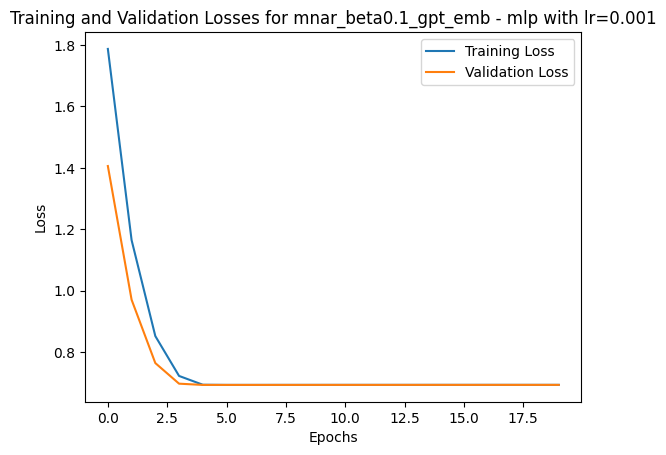

C:\Users\kr3164\AppData\Local\Temp\ipykernel_16868\387369434.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs\baseline_mlp_mnar_beta0.1_gpt_emb_lr0.001.pt


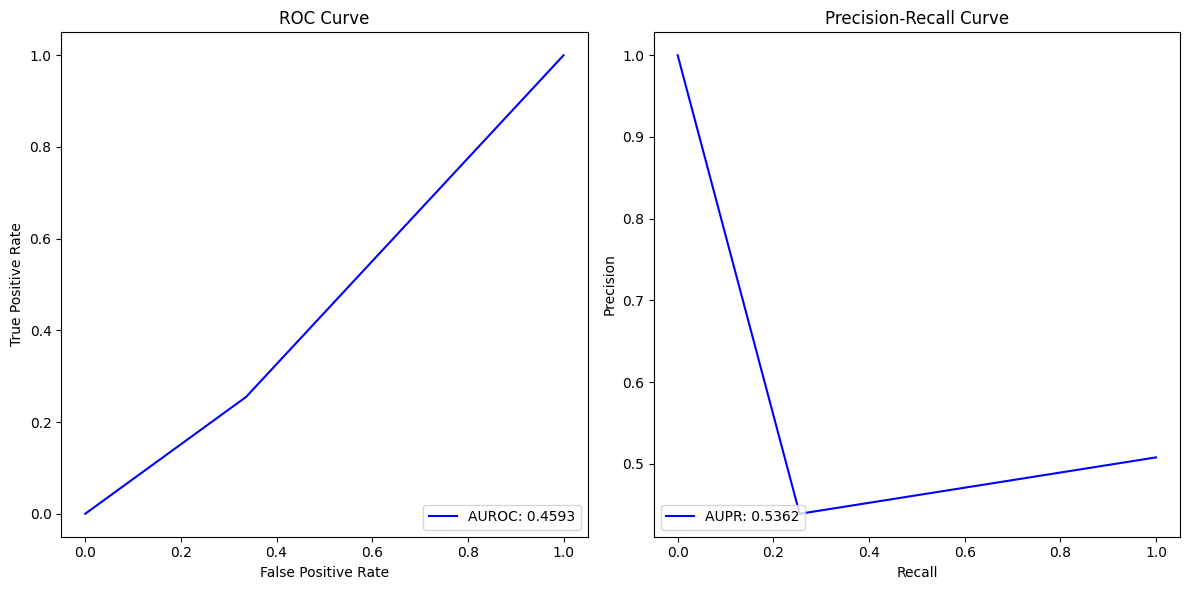

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 1.8113782917658487
Epoch [1/2000], Val Loss: 1.4302761163711548


In [4]:
import torch
import pickle
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Set the device for PyTorch (use 'cuda' for GPU if available)
device = torch.device('cpu')  # Change to 'cuda' if using GPU
random.seed(111)

# Define model parameters (modify as per your requirements)
model_name = 'mlp'
input_dim = 1
hidden_dim = 1536
dropout_rate = 0.5
learning_rate = 0.001

# Ensure the output directory exists
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

# List of files to process
file_list = [
    "extracted_data/GPT embeddings/mnar_beta0.1_gpt_emb.pickle",
    "extracted_data/GPT embeddings/mcar_beta0.1_gpt_emb.pickle"
]

# Process each file
for filename in file_list:
    # Load the dataset
    with open(filename, 'rb') as handle:
        trends_data = pickle.load(handle)

    # Initialize the Training class with specified parameters
    training = Training(
        trends_data,
        model=model_name,
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        device=device,
        dropout=dropout_rate
    )

    # Run the training process with the specified learning rate
    best_model, train_loss, val_loss = training.training(lr=learning_rate)  # Pass the learning rate here

    # Extract the dataset name without the file extension
    name = os.path.splitext(os.path.basename(filename))[0]

    # Define paths for saving model and loss data
    model_save_path = os.path.join(output_dir, f'baseline_{model_name}_{name}_lr{learning_rate}.pt')
    train_loss_save_path = os.path.join(output_dir, f'train_losses_{model_name}_{name}_lr{learning_rate}.pickle')
    val_loss_save_path = os.path.join(output_dir, f'val_losses_{model_name}_{name}_lr{learning_rate}.pickle')

    # Save the trained model
    try:
        torch.save(best_model, model_save_path)
        print(f"Model saved as {model_save_path}")
    except Exception as e:
        print(f"Error saving model: {e}")

    # Save training and validation losses
    with open(train_loss_save_path, 'wb') as handle:
        pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Training losses saved as {train_loss_save_path}")

    with open(val_loss_save_path, 'wb') as handle:
        pickle.dump(val_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Validation losses saved as {val_loss_save_path}")

    # Plot training and validation losses
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.title(f'Training and Validation Losses for {name} - {model_name} with lr={learning_rate}')
    plt.show()

    # Initialize the test loader and load the trained model
    test_loader = training.data_splits.test_loader
    model = training.model

    # Load the trained model state if it exists
    if os.path.exists(model_save_path):
        try:
            model.load_state_dict(torch.load(model_save_path, map_location=device))
            print(f"Model loaded from {model_save_path}")
        except Exception as e:
            print(f"Error loading model: {e}")
    else:
        print(f"Model file not found: {model_save_path}")

    # Function to create a padding mask
    def create_padding_mask(seq_lengths, max_len):
        batch_size = len(seq_lengths)
        mask = torch.zeros(batch_size, max_len, dtype=torch.bool)
        for i, seq_len in enumerate(seq_lengths):
            mask[i, seq_len:] = True
        return mask

    # Evaluate the model
    model.eval()
    all_outputs, all_labels = [], []
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.float().to(device)
            seq_lengths = [len(seq[seq != 0]) for seq in sequences]
            max_len = sequences.size(1)
            mask = create_padding_mask(seq_lengths, max_len).to(device)
            outputs = model(sequences, mask)
            all_outputs.extend(outputs.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

    # Function to plot ROC and PR curves
    def roc_pr(outputs, labels, plot='yes'):
        fpr, tpr, _ = roc_curve(np.array(labels), np.array(outputs))
        pre, rec, _ = precision_recall_curve(np.array(labels), np.array(outputs))

        if plot == 'yes':
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
            roc_auc = auc(fpr, tpr)
            ax1.plot(fpr, tpr, color='b', label=f'AUROC: {roc_auc:.4f}')
            pr_auc = auc(rec, pre)
            ax2.plot(rec, pre, color='b', label=f'AUPR: {pr_auc:.4f}')
            ax1.set_title('ROC Curve')
            ax1.set_xlabel('False Positive Rate')
            ax1.set_ylabel('True Positive Rate')
            ax1.legend(loc="lower right")
            ax2.set_title('Precision-Recall Curve')
            ax2.set_xlabel('Recall')
            ax2.set_ylabel('Precision')
            ax2.legend(loc="lower left")
            plt.tight_layout()
            plt.show()

    # Plot ROC and PR curves
    roc_pr(all_outputs, all_labels, plot='yes')